# Fine-Tuning Object Detection on a Custom Dataset 🖼, Deployment in Spaces, and Gradio API Integration


_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

In this notebook, we will fine-tune an [object detection](https://huggingface.co/docs/transformers/tasks/object_detection) model—specifically, [DETR](https://huggingface.co/docs/transformers/model_doc/detr)—using a custom dataset. We will leverage the [Hugging Face ecosystem](https://huggingface.co/docs) to accomplish this task.

Our approach involves starting with a pretrained DETR model and fine-tuning it on a custom dataset of annotated fashion images, namely [Fashionpedia](https://huggingface.co/datasets/detection-datasets/fashionpedia). By doing so, we'll adapt the model to better recognize and detect objects within the fashion domain.

After successfully fine-tuning the model, we will deploy it as a Gradio Space on Hugging Face. Additionally, we’ll explore how to interact with the deployed model using the Gradio API, enabling seamless communication with the hosted Space and unlocking new possibilities for real-world applications.

![DETR architecture](https://github.com/facebookresearch/detr/raw/main/.github/DETR.png)



## 1. Install Dependencies

Let's start by installing the necessary libraries for fine-tuning our object detection model.


In [ ]:
!pip install -U -q datasets transformers[torch] timm wandb torchmetrics
# Tested with datasets==2.21.0, transformers==4.44.2 timm==1.0.9, wandb==0.17.9 torchmetrics==1.4.1

## 2. Load Dataset 📁

<img src="https://fashionpedia.github.io/home/img/dataset/teaser.png" alt="Dataset sample" width="80%">

📁 The dataset we will use is [Fashionpedia](https://huggingface.co/datasets/detection-datasets/fashionpedia), which comes from the paper [Fashionpedia: Ontology, Segmentation, and an Attribute Localization Dataset](https://arxiv.org/abs/2004.12276). The authors describe it as follows:


````
Fashionpedia is a dataset which consists of two parts: (1) an ontology built by fashion experts containing 27 main apparel categories, 19 apparel parts, 294 fine-grained attributes and their relationships; (2) a dataset with 48k everyday and celebrity event fashion images annotated with segmentation masks and their associated per-mask fine-grained attributes, built upon the Fashionpedia ontology.
````

The dataset includes:

* **46,781 images** 🖼
* **342,182 bounding boxes** 📦

It is available on Hugging Face: [Fashionpedia Dataset](https://huggingface.co/datasets/detection-datasets/fashionpedia)

In [ ]:
from datasets import load_dataset

dataset = load_dataset('detection-datasets/fashionpedia')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 45623
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1158
    })
})

Review the internal structure of one of the examples

In [ ]:
dataset["train"][0]

{'image_id': 23,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=682x1024>,
 'width': 682,
 'height': 1024,
 'objects': {'bbox_id': [150311, 150312, 150313, 150314],
  'category': [23, 23, 33, 10],
  'bbox': [[445.0, 910.0, 505.0, 983.0],
   [239.0, 940.0, 284.0, 994.0],
   [298.0, 282.0, 386.0, 352.0],
   [210.0, 282.0, 448.0, 665.0]],
  'area': [1422, 843, 373, 56375]}}

## 3. Get Splits of the Dataset for Training and Testing ➗

The dataset comes with two splits: **train** and **test**. We will use the training split to fine-tune the model and the test split for validation.

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['val']

**Optional**

In the next commented cell, we randomly sample 1% of the original dataset for both the training and test splits. This approach is used to speed up the training process, as the dataset contains a large number of examples.

For the best results, we recommend skipping these two cells and using the full dataset. However, you can uncomment them if needed.

In [ ]:
'''
def create_sample(dataset, sample_fraction=0.01, seed=42):
    sample_size = int(sample_fraction * len(dataset))
    sampled_dataset = dataset.shuffle(seed=seed).select(range(sample_size))
    print(f"Original size: {len(dataset)}")
    print(f"Sample size: {len(sampled_dataset)}")
    return sampled_dataset

# Apply function to both splits
train_dataset = create_sample(train_dataset)
test_dataset = create_sample(test_dataset)
'''

## 4. Visualize One Example from the Dataset with Its Objects 👀

Now that we've loaded the dataset, let's visualize an example along with its annotated objects.


### Generate `id2label` and `label2id`

These variables contain the mappings between object IDs and their corresponding labels. `id2label` maps from IDs to labels, while `label2id` maps from labels to IDs.

In [ ]:
import numpy as np
from PIL import Image, ImageDraw


id2label = {
    0: 'shirt, blouse', 1: 'top, t-shirt, sweatshirt', 2: 'sweater', 3: 'cardigan',
    4: 'jacket', 5: 'vest', 6: 'pants', 7: 'shorts', 8: 'skirt', 9: 'coat',
    10: 'dress', 11: 'jumpsuit', 12: 'cape', 13: 'glasses', 14: 'hat',
    15: 'headband, head covering, hair accessory', 16: 'tie', 17: 'glove',
    18: 'watch', 19: 'belt', 20: 'leg warmer', 21: 'tights, stockings',
    22: 'sock', 23: 'shoe', 24: 'bag, wallet', 25: 'scarf', 26: 'umbrella',
    27: 'hood', 28: 'collar', 29: 'lapel', 30: 'epaulette', 31: 'sleeve',
    32: 'pocket', 33: 'neckline', 34: 'buckle', 35: 'zipper', 36: 'applique',
    37: 'bead', 38: 'bow', 39: 'flower', 40: 'fringe', 41: 'ribbon',
    42: 'rivet', 43: 'ruffle', 44: 'sequin', 45: 'tassel'
}


label2id = {v: k for k, v in id2label.items()}

### Let's Draw One Image! 🎨

Now, let's visualize one image from the dataset to better understand what it looks like.

{'bbox_id': [158977, 158978, 158979, 158980, 158981, 158982, 158983], 'category': [1, 23, 23, 6, 31, 31, 33], 'bbox': [[210.0, 225.0, 536.0, 784.0], [290.0, 897.0, 350.0, 1015.0], [464.0, 950.0, 534.0, 1021.0], [313.0, 407.0, 524.0, 954.0], [268.0, 229.0, 333.0, 563.0], [489.0, 247.0, 528.0, 591.0], [387.0, 225.0, 450.0, 253.0]], 'area': [69960, 2449, 1788, 75418, 15149, 5998, 479]}


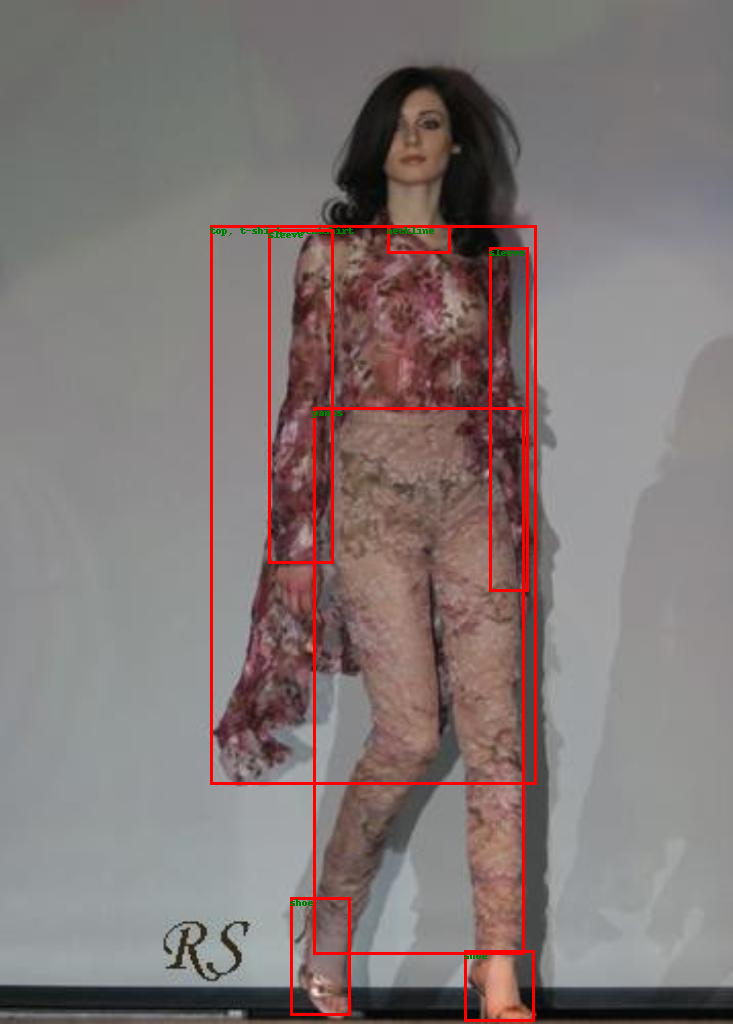

In [ ]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    print(annotations)

    for i in range(len(annotations["bbox_id"])):
        box = annotations["bbox"][i]
        x1, y1, x2, y2 = tuple(box)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
        draw.text((x1, y1), id2label[annotations["category"][i]], fill="green")

    return image

draw_image_from_idx(dataset=train_dataset, idx=10) # You can test changing this id

### Let's Visualize Some More Images 📸

Now, let's take a look at a few more images from the dataset to get a broader view of the data.

{'bbox_id': [150311, 150312, 150313, 150314], 'category': [23, 23, 33, 10], 'bbox': [[445.0, 910.0, 505.0, 983.0], [239.0, 940.0, 284.0, 994.0], [298.0, 282.0, 386.0, 352.0], [210.0, 282.0, 448.0, 665.0]], 'area': [1422, 843, 373, 56375]}
{'bbox_id': [158953, 158954, 158955, 158956, 158957, 158958, 158959, 158960, 158961, 158962], 'category': [2, 33, 31, 31, 13, 7, 22, 22, 23, 23], 'bbox': [[182.0, 220.0, 472.0, 647.0], [294.0, 221.0, 407.0, 257.0], [405.0, 297.0, 472.0, 647.0], [182.0, 264.0, 266.0, 621.0], [284.0, 135.0, 372.0, 169.0], [238.0, 537.0, 414.0, 606.0], [351.0, 732.0, 417.0, 922.0], [202.0, 749.0, 270.0, 930.0], [200.0, 921.0, 256.0, 979.0], [373.0, 903.0, 455.0, 966.0]], 'area': [87267, 1220, 16895, 18541, 1468, 9360, 8629, 8270, 2717, 3121]}
{'bbox_id': [169196, 169197, 169198, 169199, 169200, 169201, 169202, 169203, 169204, 169205, 169206, 169207, 169208, 169209, 169210], 'category': [13, 29, 28, 32, 32, 31, 31, 0, 31, 31, 18, 4, 6, 23, 23], 'bbox': [[441.0, 132.0, 499

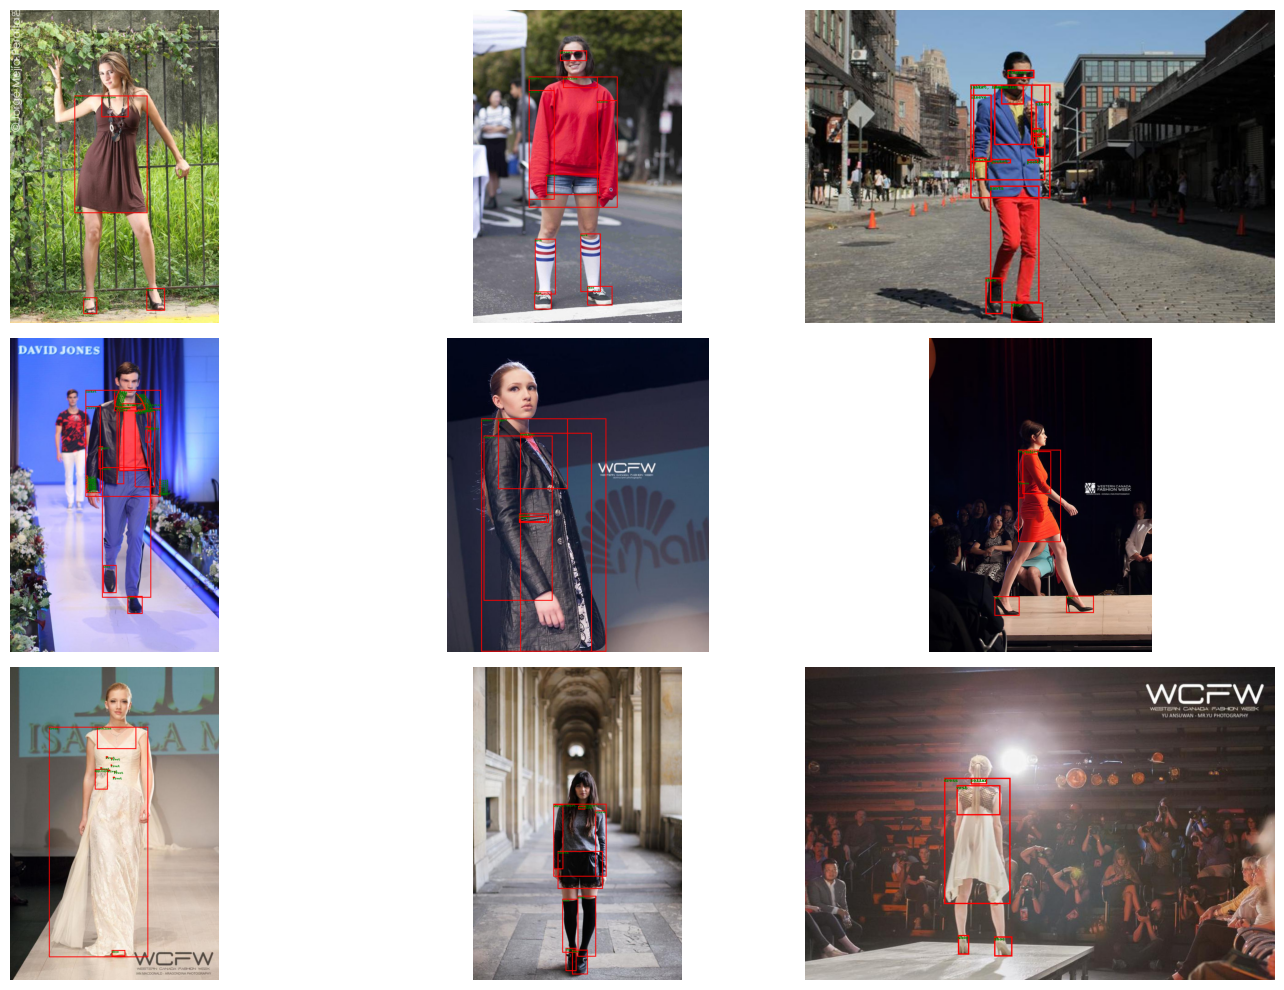

In [ ]:
import matplotlib.pyplot as plt

def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_cols = 3
    num_rows = int(np.ceil(len(indices) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        image = draw_image_from_idx(dataset, idx)

        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

plot_images(train_dataset, range(9))

## 5. Filter Invalid Bboxes ❌

As the first step in preprocessing the dataset, we will filter out some invalid bounding boxes. After reviewing the dataset, we found that some bounding boxes did not have a valid structure. Therefore, we will discard these invalid entries.

In [ ]:
from datasets import Dataset

def filter_invalid_bboxes(example):
    valid_bboxes = []
    valid_bbox_ids = []
    valid_categories = []
    valid_areas = []

    for i, bbox in enumerate(example['objects']['bbox']):
        x_min, y_min, x_max, y_max = bbox[:4]
        if x_min < x_max and y_min < y_max:
            valid_bboxes.append(bbox)
            valid_bbox_ids.append(example['objects']['bbox_id'][i])
            valid_categories.append(example['objects']['category'][i])
            valid_areas.append(example['objects']['area'][i])
        else:
            print(f"Image with invalid bbox: {example['image_id']} Invalid bbox detected and discarded: {bbox} - bbox_id: {example['objects']['bbox_id'][i]} - category: {example['objects']['category'][i]}")

    example['objects']['bbox'] = valid_bboxes
    example['objects']['bbox_id'] = valid_bbox_ids
    example['objects']['category'] = valid_categories
    example['objects']['area'] = valid_areas

    return example

train_dataset = train_dataset.map(filter_invalid_bboxes)
test_dataset = test_dataset.map(filter_invalid_bboxes)

Map:   0%|          | 0/45623 [00:00<?, ? examples/s]

Image with invalid bbox: 8396 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 139952 - category: 42
Image with invalid bbox: 19725 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 23298 - category: 42
Image with invalid bbox: 19725 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 23299 - category: 42
Image with invalid bbox: 21696 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 277148 - category: 42
Image with invalid bbox: 23055 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 287029 - category: 33
Image with invalid bbox: 23671 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 290142 - category: 42
Image with invalid bbox: 26549 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 311943 - category: 37
Image with invalid bbox: 26834 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 309141 - category: 37
Image with invalid bbox: 31

Map:   0%|          | 0/1158 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 45623
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 1158
})


## 6. Visualize Class Occurrences 👀

Let's explore the dataset further by plotting the occurrences of each class. This will help us understand the distribution of classes and identify any potential biases.

In [ ]:
id_list = []
category_examples = {}
for example in train_dataset:
  id_list += example['objects']['bbox_id']
  for category in example['objects']['category']:
    if id2label[category] not in category_examples:
      category_examples[id2label[category]] = 1
    else:
      category_examples[id2label[category]] += 1

id_list.sort()

<ipython-input-66-aa111d1e000d>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=90, ha='right')


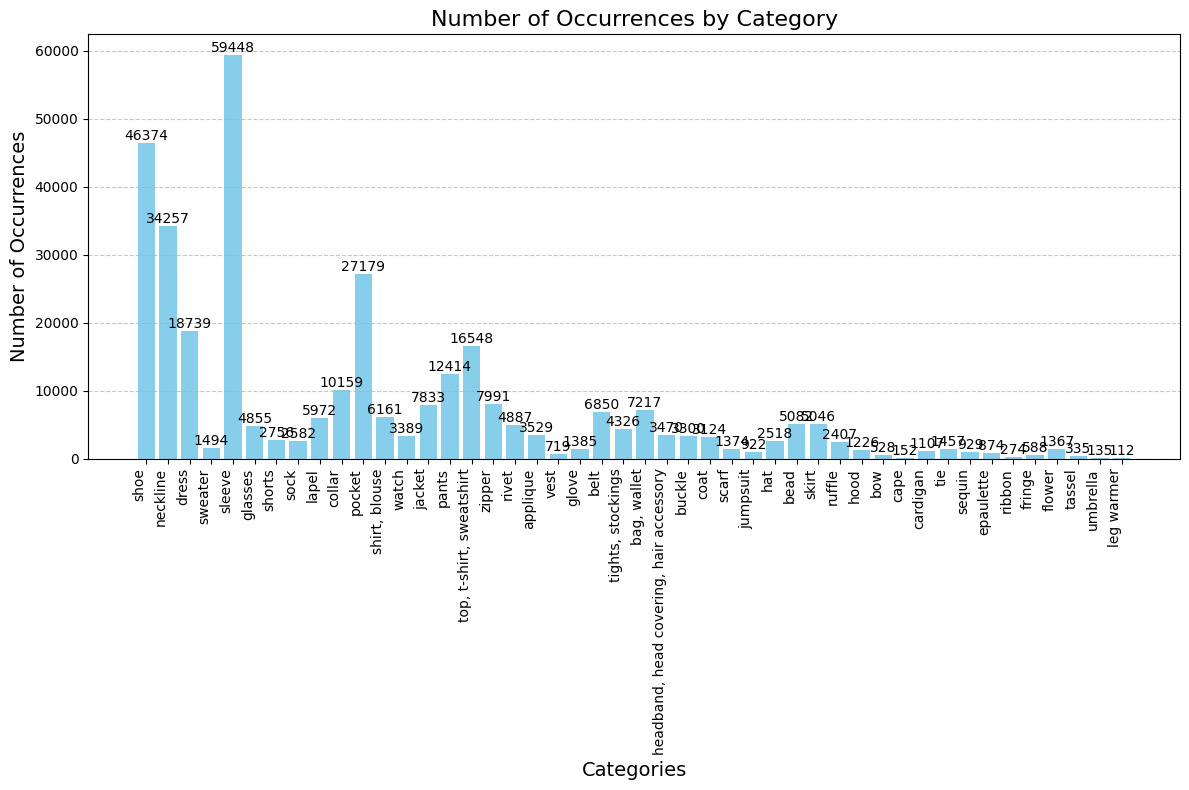

In [ ]:
import matplotlib.pyplot as plt

categories = list(category_examples.keys())
values = list(category_examples.values())

fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(categories, values, color='skyblue')

ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Number of Occurrences', fontsize=14)
ax.set_title('Number of Occurrences by Category', fontsize=16)

ax.set_xticklabels(categories, rotation=90, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0, height,
        f'{height}', ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

We can observe that some classes, such as "shoe" or "sleeve," are overrepresented in the dataset. This indicates that the dataset may have an imbalance, with certain classes appearing more frequently than others. Identifying these imbalances is crucial for addressing potential biases in model training.


## 7. Add Data Augmentation to the Dataset

Data augmentation 🪄 is crucial for enhancing performance in object detection tasks. In this section, we will leverage the capabilities of [Albumentations](https://albumentations.ai/) to augment our dataset effectively.

Albumentations provides a range of powerful augmentation techniques tailored for object detection. It allows for various transformations, all while ensuring that bounding boxes are accurately adjusted. These capabilities help in generating a more diverse dataset, improving the model’s robustness and generalization.

<img src="https://albumentations.ai/docs/images/introduction/dedicated_library/pixel_and_spatial_level_augmentations_for_object_detection.jpg" alt="Albumentations image" width="90%">

In [ ]:
import albumentations as A

train_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"]
    ),
)

val_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"]
    ),
)

## 8. Initialize Image Processor from Model Checkpoint 🎆

We will instantiate the image processor using a pretrained model checkpoint. In this case, we are using the [facebook/detr-resnet-50-dc5](https://huggingface.co/facebook/detr-resnet-50-dc5) model.


In [ ]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


### Adding Methods to Process the Dataset

We will now add methods to process the dataset. These methods will handle tasks such as transforming images and annotations to ensure they are compatible with the model.




In [ ]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

def convert_voc_to_coco(bbox):
    xmin, ymin, xmax, ymax = bbox
    width = xmax - xmin
    height = ymax - ymin
    return [xmin, ymin, width, height]

def transform_aug_ann(examples, transform):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])

        # Convert to COCO format
        converted_bboxes = [convert_voc_to_coco(bbox) for bbox in out["bboxes"]]
        bboxes.append(converted_bboxes)

        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def transform_train(examples):
    return transform_aug_ann(examples, transform=train_transform)

def transform_val(examples):
    return transform_aug_ann(examples, transform=val_transform)


train_dataset_transformed = train_dataset.with_transform(transform_train)
test_dataset_transformed = test_dataset.with_transform(transform_val)

## 9. Plot Augmented Examples 🎆

We are nearing the model training phase! Before proceeding, let’s visualize some samples after augmentation. This will allow us to double-check that the augmentations are suitable and effective for the training process.


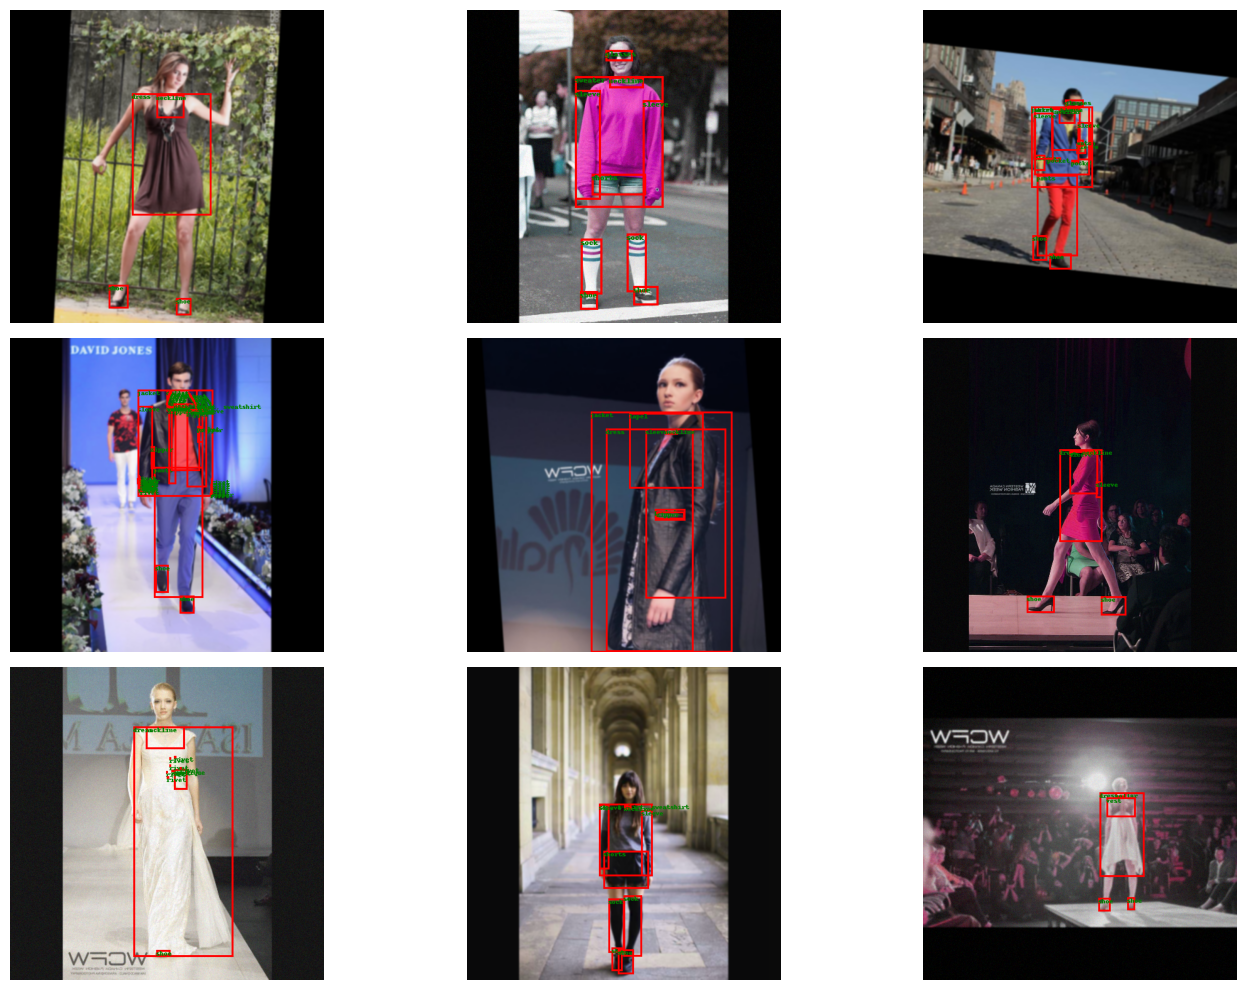

In [ ]:
# Updated draw function to accept an optional transform
def draw_augmented_image_from_idx(dataset, idx, transform=None):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]

    # Convert image to RGB and NumPy array
    image = np.array(image.convert("RGB"))[:, :, ::-1]

    if transform:
        augmented = transform(image=image, bboxes=annotations["bbox"], category=annotations["category"])
        image = augmented["image"]
        annotations["bbox"] = augmented["bboxes"]
        annotations["category"] = augmented["category"]

    image = Image.fromarray(image[:, :, ::-1])  # Convert back to PIL Image
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["bbox_id"])):
        box = annotations["bbox"][i]
        x1, y1, x2, y2 = tuple(box)

        # Normalize coordinates if necessary
        if max(box) <= 1.0:
            x1, y1 = int(x1 * width), int(y1 * height)
            x2, y2 = int(x2 * width), int(y2 * height)
        else:
            x1, y1 = int(x1), int(y1)
            x2, y2 = int(x2), int(y2)

        draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
        draw.text((x1, y1), id2label[annotations["category"][i]], fill="green")

    return image

# Updated plot function to include augmentation
def plot_augmented_images(dataset, indices, transform=None):
    """
    Plot images and their annotations with optional augmentation.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw augmented image
        image = draw_augmented_image_from_idx(dataset, idx, transform=transform)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

# Now use the function to plot augmented images
plot_augmented_images(train_dataset, range(9), transform=train_transform)

## 10. Initialize Model from Checkpoint

We will initialize the model using the same checkpoint as the image processor. This involves loading a pretrained model that we will fine-tune for our specific dataset.


In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

In [ ]:
output_dir = "detr-resnet-50-dc5-fashionpedia-finetuned" # change this

## 10. Connect to HF Hub to Upload Fine-Tuned Model 🔌

We will connect to the Hugging Face Hub to upload our fine-tuned model. This allows us to share and deploy the model for others to use or for further evaluation.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 11. Set Training Arguments, Connect to W&B, and Train! <img src="https://wandb.ai/logo.png" alt="W&B logo" width="3%">

Next, we will set up the training arguments, connect to [Weights & Biases (W&B)](https://wandb.ai/), and start the training process. W&B will help us track experiments, visualize metrics, and manage our model training workflow.






In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

import torch

# Define the training arguments

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=10000,
    fp16=True,
    save_steps=10,
    logging_steps=1,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    evaluation_strategy="steps",
    eval_steps=50,
    eval_strategy = "steps",
    report_to="wandb",
    push_to_hub=True,
    batch_eval_metrics=True
)

### Connect to W&B to Track Training

In [ ]:
import wandb

wandb.init(
    project="detr-resnet-50-dc5-fashionpedia-finetuned", # change this
    name="detr-resnet-50-dc5-fashionpedia-finetuned", # change this
    config=training_args
)

### Let's Train the Model! 🚀

Now it’s time to start training the model. Let’s run the training process and watch how our fine-tuned model learns from the data!


First, we declare the `compute_metrics` method for calculating the metrics on evaluation.

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.nn.functional import softmax

def denormalize_boxes(boxes, width, height):
    boxes = boxes.clone()
    boxes[:, 0] *= width  # xmin
    boxes[:, 1] *= height  # ymin
    boxes[:, 2] *= width  # xmax
    boxes[:, 3] *= height  # ymax
    return boxes

batch_metrics = []
def compute_metrics(eval_pred, compute_result):
    global batch_metrics

    (loss_dict, scores, pred_boxes, last_hidden_state, encoder_last_hidden_state), labels = eval_pred

    image_sizes = []
    target = []
    for label in labels:

        image_sizes.append(label['orig_size'])
        width, height = label['orig_size']
        denormalized_boxes = denormalize_boxes(label["boxes"], width, height)
        target.append(
            {
                "boxes": denormalized_boxes,
                "labels": label["class_labels"],
            }
        )
    predictions = []
    for score, box, target_sizes in zip(scores, pred_boxes, image_sizes):
        # Extract the bounding boxes, labels, and scores from the model's output
        pred_scores = score[:, :-1]  # Exclude the no-object class
        pred_scores = softmax(pred_scores, dim=-1)
        width, height = target_sizes
        pred_boxes = denormalize_boxes(box, width, height)
        pred_labels = torch.argmax(pred_scores, dim=-1)

        # Get the scores corresponding to the predicted labels
        pred_scores_for_labels = torch.gather(pred_scores, 1, pred_labels.unsqueeze(-1)).squeeze(-1)
        predictions.append(
            {
                "boxes": pred_boxes,
                "scores": pred_scores_for_labels,
                "labels": pred_labels,
            }
        )

    metric = MeanAveragePrecision(box_format='xywh', class_metrics=True)

    if not compute_result:
        # Accumulate batch-level metrics
        batch_metrics.append({"preds": predictions, "target": target})
        return {}
    else:
        # Compute final aggregated metrics
        # Aggregate batch-level metrics (this should be done based on your metric library's needs)
        all_preds = []
        all_targets = []
        for batch in batch_metrics:
            all_preds.extend(batch["preds"])
            all_targets.extend(batch["target"])

        # Update metric with all accumulated predictions and targets
        metric.update(preds=all_preds, target=all_targets)
        metrics = metric.compute()

        # Convert and format metrics as needed
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")

        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        # Round metrics for cleaner output
        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        # Clear batch metrics for next evaluation
        batch_metrics = []

        return metrics

In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]

    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels

    return batch

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()

## 12. Test How the Model Behaves on a Test Image 📝

Now that the model is trained, we can evaluate its performance on a test image. Since the model is available as a Hugging Face model, making predictions is straightforward. In the following cell, we will demonstrate how to run inference on a new image and assess the model's capabilities.



In [ ]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

url = "https://images.pexels.com/photos/27980131/pexels-photo-27980131/free-photo-of-mar-moda-hombre-pareja.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2"

image = Image.open(requests.get(url, stream=True).raw)

obj_detector = pipeline(
    "object-detection", model="sergiopaniego/detr-resnet-50-dc5-fashionpedia-finetuned" # Change with your model name
)


results = obj_detector(image)
print(results)

### Now, Let's Show the Results

We’ll display the results of the model’s predictions on the test image. This will give us insight into how well the model performs and highlight its strengths and areas for improvement.


In [ ]:
from PIL import Image, ImageDraw
import numpy as np

def plot_results(image, results, threshold=0.6):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    width, height = image.size

    for result in results:
        score = result['score']
        label = result['label']
        box = list(result['box'].values())

        if score > threshold:
            x1, y1, x2, y2 = tuple(box)
            draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
            draw.text((x1 + 5, y1 - 10), label, fill="white")
            draw.text((x1 + 5, y1 + 10), f'{score:.2f}', fill='green' if score > 0.7 else 'red')

    return image

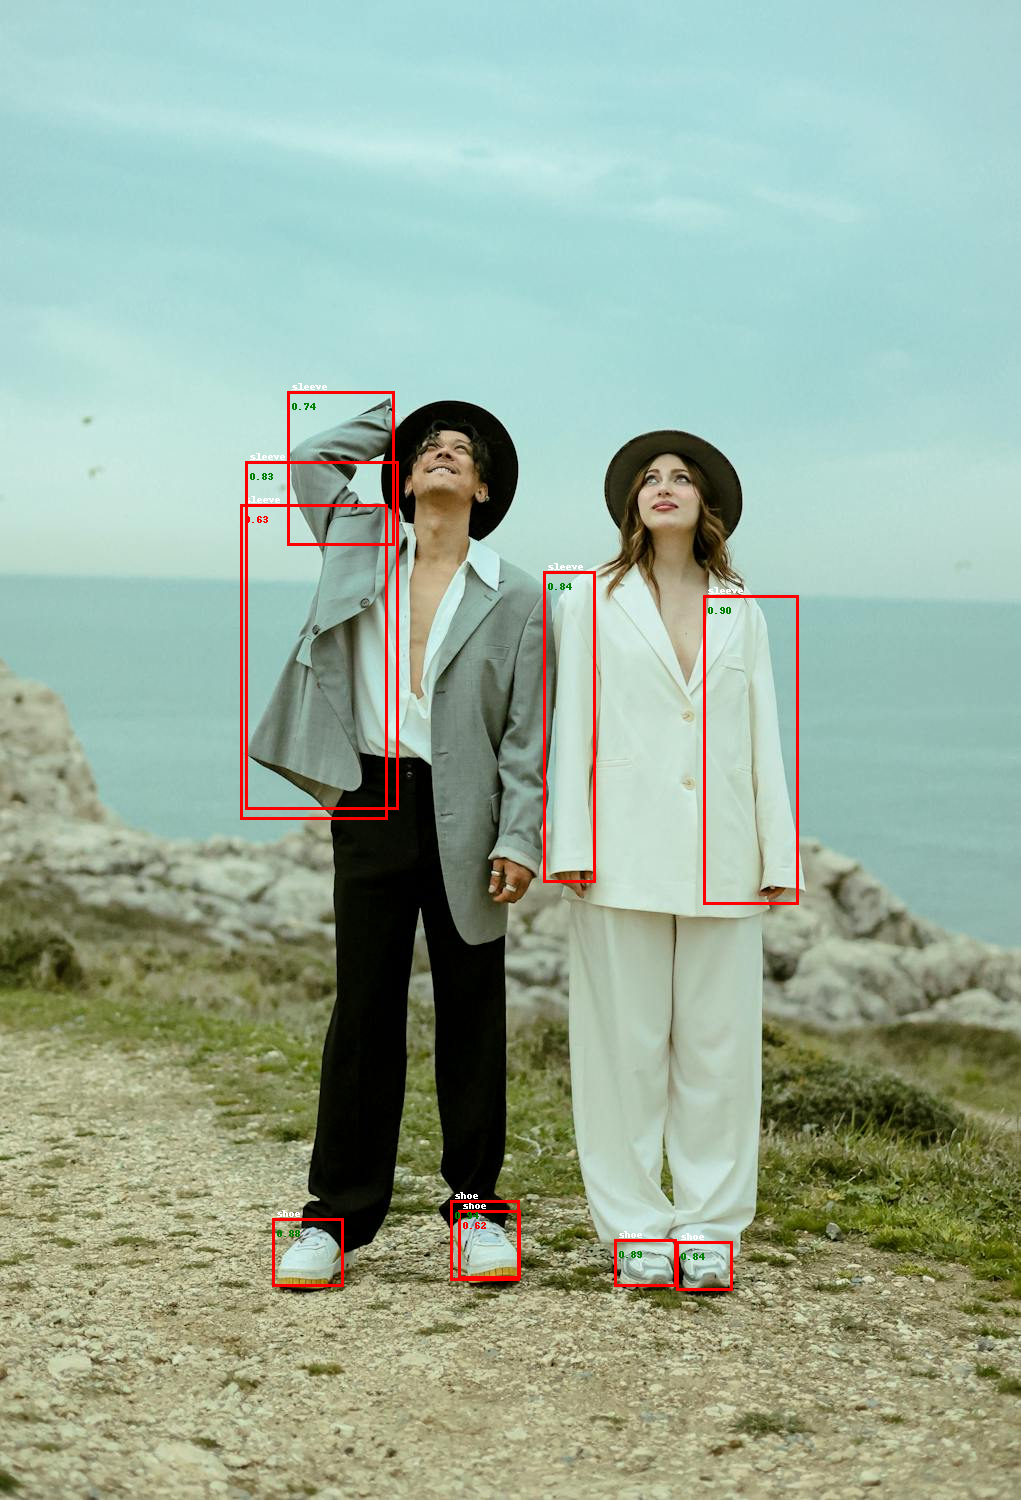

In [ ]:
plot_results(image, results)

## 13. Evaluation of the Model on the Test Set 📝

After training and visualizing the results for a test image, we will evaluate the model on the entire test dataset. This step involves generating metrics to assess the overall performance and effectiveness of the model across the full range of test samples.


In [ ]:
metrics = trainer.evaluate(test_dataset_transformed)
print(metrics)

## 14. Deploy the Model in a HF Space <img src="https://seeklogo.com/images/G/gradio-icon-logo-908AE1836C-seeklogo.com.png" alt="Gradio logo" width="5%">

<img src="https://huggingface.co/front/thumbnails/spaces.png" alt="HF Spaces logo" width="20%">

Now that our model is available on Hugging Face, we can deploy it in a HF Space. Hugging Face provides free Spaces for small applications, allowing us to create an interactive web application where users can upload test images and evaluate the model's capabilities.

I’ve created an example application here: [DETR Object Detection Fashionpedia - Fine-Tuned](https://huggingface.co/spaces/sergiopaniego/DETR_object_detection_fashionpedia-finetuned)


In [ ]:
from IPython.display import IFrame
IFrame(src='https://sergiopaniego-detr-object-detection-fashionpedia-fa0081f.hf.space', width=1000, height=800)

### Create the Application with the Following Code

You can create a new application by copying and pasting the following code into a file named `app.py`.


In [ ]:
# app.py

import gradio as gr
import spaces
import torch

from PIL import Image
from transformers import pipeline
import matplotlib.pyplot as plt
import io

model_pipeline = pipeline("object-detection", model="sergiopaniego/detr-resnet-50-dc5-fashionpedia-finetuned")


COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


def get_output_figure(pil_img, results, threshold):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100

    for result in results:
        score = result['score']
        label = result['label']
        box = list(result['box'].values())
        if score > threshold:
            c = COLORS[hash(label) % len(COLORS)]
            ax.add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color=c, linewidth=3))
            text = f'{label}: {score:0.2f}'
            ax.text(box[0], box[1], text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')

    return plt.gcf()

@spaces.GPU
def detect(image):
    results = model_pipeline(image)
    print(results)

    output_figure = get_output_figure(image, results, threshold=0.7)

    buf = io.BytesIO()
    output_figure.savefig(buf, bbox_inches='tight')
    buf.seek(0)
    output_pil_img = Image.open(buf)

    return output_pil_img

with gr.Blocks() as demo:
    gr.Markdown("# Object detection with DETR fine tuned on detection-datasets/fashionpedia")
    gr.Markdown(
        """
        This application uses a fine tuned DETR (DEtection TRansformers) to detect objects on images.
        This version was trained using detection-datasets/fashionpedia dataset.
        You can load an image and see the predictions for the objects detected.
        """
    )

    gr.Interface(
        fn=detect,
        inputs=gr.Image(label="Input image", type="pil"),
        outputs=[
            gr.Image(label="Output prediction", type="pil")
        ]
    )

demo.launch(show_error=True)

### Remember to Set Up `requirements.txt`

Don’t forget to create a `requirements.txt` file to specify the dependencies for the application.


In [ ]:
# requirements.txt

transformers
timm
torch

## 15. Access the Space as an API 🧑‍💻️

One of the great features of Hugging Face Spaces is that they provide an API that can be accessed from outside applications. This makes it easy to integrate the model into various applications, whether they’re built with JavaScript, Python, or another language. Imagine the possibilities for expanding and utilizing your model’s capabilities!

You can find more information on how to use the API here: [Hugging Face Enterprise Cookbook: Gradio](https://huggingface.co/learn/cookbook/enterprise_cookbook_gradio)


In [ ]:
!pip install gradio_client

In [ ]:
from gradio_client import Client, handle_file

url = "https://images.pexels.com/photos/27980131/pexels-photo-27980131/free-photo-of-mar-moda-hombre-pareja.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2"

image = Image.open(requests.get(url, stream=True).raw)

client = Client("sergiopaniego/DETR_object_detection_fashionpedia-finetuned") # change this with your Space
result = client.predict(
		image=handle_file("https://images.pexels.com/photos/27980131/pexels-photo-27980131/free-photo-of-mar-moda-hombre-pareja.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2"),
		api_name="/predict"
)

In [ ]:
from PIL import Image

img = Image.open(result).convert('RGB')

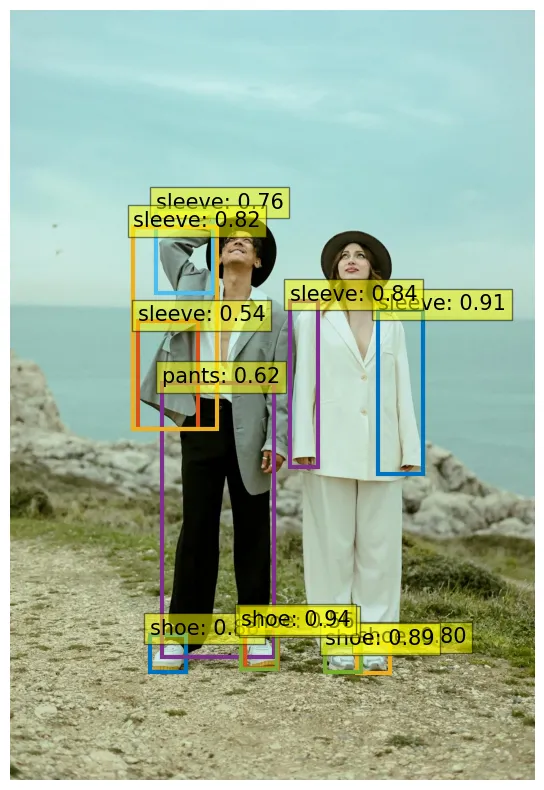

In [ ]:
from IPython.display import display
display(img)

## Conclusion

In this cookbook, we successfully fine-tuned an object detection model on a custom dataset and deployed it as a Gradio Space. We also demonstrated how to call the Space using the Gradio API, showcasing the ease of integrating it into various applications.

I hope this guide helps you in fine-tuning and deploying your own models with confidence! 🚀
